# **Fundamentos de datos y analytics**
**Josefina Valenzuela L.**

*Diplomado Data Engineer*
*USACH*
*(Módulo Machine Learning)*

### **Escalabilidad de datos con Dask y Pandas**

Clase práctica de Machine Learning y análisis de datos a gran escala. Usaremos el dataset de viajes en taxi de NYC para explorar cómo trabajar con datos masivos usando Pandas y Dask.

In [ ]:
# Instalación de librerías necesarias
!pip install dask[complete] seaborn --quiet

# Descargar el archivo Parquet desde NYC Open Data
!wget -q https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00


In [ ]:
# Importar librerías
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np


In [ ]:
# Cargar el dataset con Pandas
start_pandas = time.time()
df_pandas = pd.read_parquet("yellow_tripdata_2022-01.parquet")
end_pandas = time.time()
print(f"Pandas cargó {len(df_pandas)} filas en {end_pandas - start_pandas:.2f} segundos.")


Pandas cargó 2463931 filas en 1.21 segundos.


In [ ]:
# Cargar el dataset con Dask
start_dask = time.time()
df_dask = dd.read_parquet("yellow_tripdata_2022-01.parquet")
df_dask_rows = df_dask.shape[0].compute()
end_dask = time.time()
print(f"Dask cargó {df_dask_rows} filas en {end_dask - start_dask:.2f} segundos.")


Dask cargó 2463931 filas en 1.29 segundos.


### Si bien Pandas carga más rápido, en la teoría Dask es más eficiente
Dask está diseñado para trabajar con datasets que no caben en memoria o que requieren procesamiento paralelo. Sus ventajas se hacen evidentes cuando:

* El dataset es muy grande (decenas de millones de filas o más).
* Estás trabajando en un entorno distribuido (nube).
* Necesitas procesamiento por partes (lazy evaluation) o pipelines complejos.

#### **Para este caso, en archivo no es lo suficientemente grande como para tener que hacer uso de las ventajas de Dask.**
* El archivo cabe en memoria: 2 millones de filas, Pandas puede cargarlo de forma muy eficiente en RAM.
* Dask tiene overhead: necesita construir un grafo de tareas y coordinar la ejecución, lo cual introduce una pequeña demora inicial.
* No está usando paralelismo real: Si estás en un entorno con pocos núcleos o sin configuración de paralelismo.
* Dask es “lazy”: muchas operaciones no se ejecutan hasta que haces .compute(), lo que puede hacer que parezca más lento si no se mide correctamente.

  #### **La pregunta es, ¿En qué momento Dask es más eficiente que Pandas?**
  Vamos a probar con la carga de datos aleatorios de 100.000, 1.000.000 y 10.000.000, 100.000.000 registros, evaluando los tiempos de ejecución de cada herramienta.

In [ ]:
def generar_dataset(n_filas):
    np.random.seed(42)
    data = {
        'id': np.arange(n_filas),
        'valor': np.random.rand(n_filas) * 100,
        'categoria': np.random.choice(['A', 'B', 'C'], size=n_filas)
    }
    return pd.DataFrame(data)

# Tamaños a probar
tamaños = [100_000, 1_000_000, 10_000_000, 100_000_000]


In [ ]:
resultados = []

for n in tamaños:
    #Se generan los dataframes y se guardan
    print(f"\n--- {n:,} filas ---")
    print(" ")
    df = generar_dataset(n)
    df.to_csv("temp.csv", index=False)
    print(df.head(10))
    print(" ")


    #Volvemos a cargar los datos para evaluar los tiempos de procesamiento.

    # Pandas
    start = time.time()
    df_pandas = pd.read_csv("temp.csv")
    df_pandas_filtrado = df_pandas[df_pandas["valor"] > 50]
    suma_pandas = df_pandas_filtrado["valor"].sum()
    tiempo_pandas = time.time() - start

    # Dask
    start = time.time()
    df_dask = dd.read_csv("temp.csv")
    df_dask_filtrado = df_dask[df_dask["valor"] > 50]
    suma_dask = df_dask_filtrado["valor"].sum().compute()
    tiempo_dask = time.time() - start

    resultados.append({
        "filas": n,
        "tiempo_pandas": tiempo_pandas,
        "tiempo_dask": tiempo_dask
    })

    print(f"Pandas: {tiempo_pandas:.2f}s, Dask: {tiempo_dask:.2f}s")



--- 100,000 filas ---
 
   id      valor categoria
0   0  37.454012         B
1   1  95.071431         B
2   2  73.199394         C
3   3  59.865848         A
4   4  15.601864         A
5   5  15.599452         B
6   6   5.808361         B
7   7  86.617615         C
8   8  60.111501         B
9   9  70.807258         B
 
Pandas: 0.08s, Dask: 0.06s

--- 1,000,000 filas ---
 
   id      valor categoria
0   0  37.454012         B
1   1  95.071431         C
2   2  73.199394         A
3   3  59.865848         C
4   4  15.601864         B
5   5  15.599452         C
6   6   5.808361         C
7   7  86.617615         B
8   8  60.111501         B
9   9  70.807258         C
 
Pandas: 0.37s, Dask: 0.40s

--- 10,000,000 filas ---
 
   id      valor categoria
0   0  37.454012         A
1   1  95.071431         A
2   2  73.199394         C
3   3  59.865848         A
4   4  15.601864         B
5   5  15.599452         B
6   6   5.808361         C
7   7  86.617615         A
8   8  60.111501         

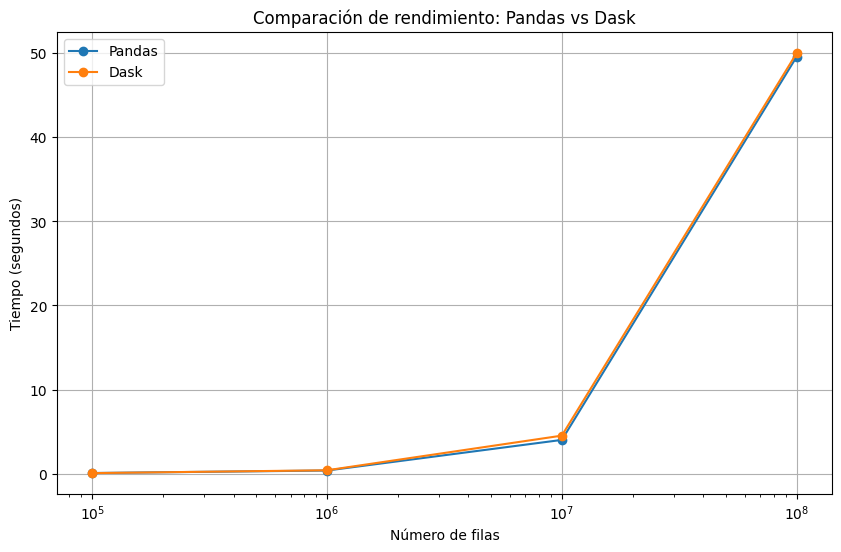

In [ ]:
df_resultados = pd.DataFrame(resultados)

plt.figure(figsize=(10, 6))
plt.plot(df_resultados["filas"], df_resultados["tiempo_pandas"], label="Pandas", marker="o")
plt.plot(df_resultados["filas"], df_resultados["tiempo_dask"], label="Dask", marker="o")
plt.xlabel("Número de filas")
plt.ylabel("Tiempo (segundos)")
plt.title("Comparación de rendimiento: Pandas vs Dask")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.show()


#### **¿Cuándo usar Pandas vs. Dask?**

* Dataset pequeño o mediano (cabe en RAM): Pandas es rápido y simple, mientras Dask implementa un overhead innecesario para este escenario.
* Dataset muy grande (no cabe en RAM): Pandas podría fallar, mientras Dask es escalable.
* Procesamiento en la nube: No es soportado por Pandas. Hace referencia a ejecutar tareas remotamente en AWS, GCP, etc.

### **Análisis Exploratorio de datos**
Se carga la base de Titanic para predecir la supervivencia de los pasajeros.

**Descripción de columnas**
* **PassengerId:** Identificador único para cada pasajero
* **Survived:** 0 = No sobrevivió, 1 = Sobrevivió
* **Pclass:** Clase del billete del pasajero: 1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase
* **Name:** Nombre completo del pasajero
* **Sex:** Sexo del pasajero: male (hombre) o female (mujer)
* **Age:** Edad del pasajero en años
* **SibSp:** Número de hermanos o cónyuges a bordo
* **Parch:** Número de padres o hijos a bordo
* **Ticket:** Número del billete
* **Fare:** Precio del billete
* **Cabin:** Número de cabina
* **Embarked:** Puerto de embarque: C = Cherburgo, Q = Queenstown, S = Southampton

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# URL directa al archivo
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

# Cargar el dataset
df = pd.read_csv(url)

# Vista previa
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Información general

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Columnas de números enteros:
* PassengerID
* Survived
* Pclass
* SibSp
* Parch

Columnas de números decimales:
* Age
* Fare

Columnas categóricas:
* Name
* Sex
* Ticket
* Cabin
* Embarked



Estadísticas descriptivas

In [ ]:
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


**Verificación de valores nulos**

In [ ]:
print("Valores nulos por columna:")
df.isnull().sum()

Valores nulos por columna:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
print("Porcentaje de nulos por variable")
df.isnull().sum()/df.shape[0]

Porcentaje de nulos por variable


,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


Variable Cabin tiene un 77% de sus datos nulos, por lo que no aporta valor al modelo.

### **Análisis Uni y Bivariable**
* Heatmap de correlaciones
* Histogramas
* Boxplots para detectar outliers
* Frecuencia de cada categoría
* Gráficos de barras

**--------------------------------------------------------------------------------**

**Age**

Esta presenta un 20% de sus datos nulos, pero al ser una variable relevante, se deben imputan los datos faltantes.


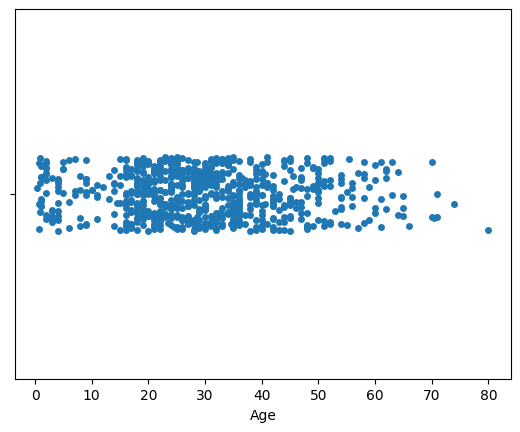

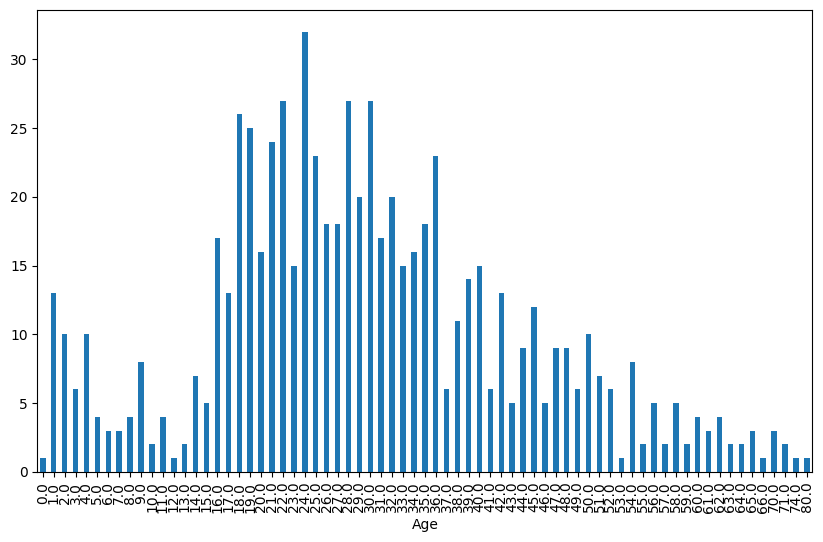

/tmp/ipython-input-2365932859.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['AgeGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
/tmp/ipython-input-2365932859.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['AgeGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)


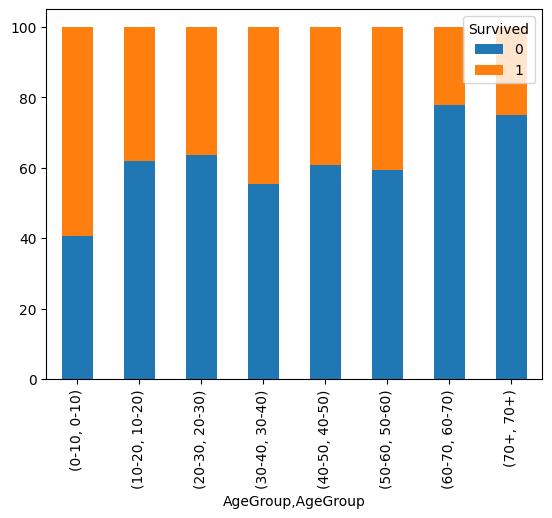

----------------------------------------------------------------------
Mínimo:  0.0
Máximo:  80.0


In [ ]:
import seaborn as sn
from os import defpath
import matplotlib.pyplot as plt
import numpy as np

sn.stripplot(x='Age', data=df)
plt.show()


df['Age'] = df['Age'].round(0)
df['Age'].value_counts().sort_index().plot.bar(figsize=(10,6))
plt.xlabel('Age')
plt.show()

# Agrupar la variable 'Age' en rangos
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, df['Fare'].max()]
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)


df.groupby(['AgeGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

del df['AgeGroup']

print("----------------------------------------------------------------------")
print("Mínimo: ", df['Age'].min())
print("Máximo: ", df['Age'].max())


Histograma color e Histograma con proporciones, para ver relevancia de la variable objetivo en los valores de una variable.
Se observan:
* Valores atípicos, con edades negativas.
* 60+ la probabilidad de sobrevivir disminuye.

**PClass**


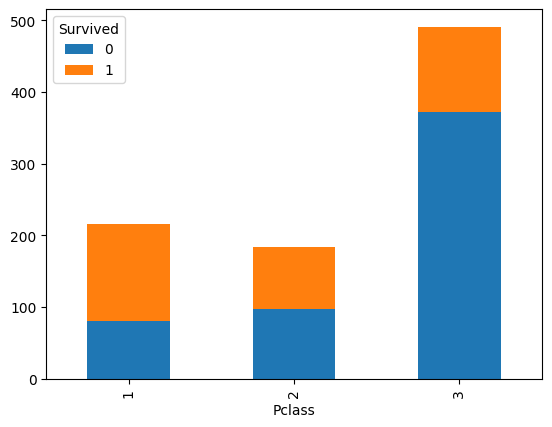

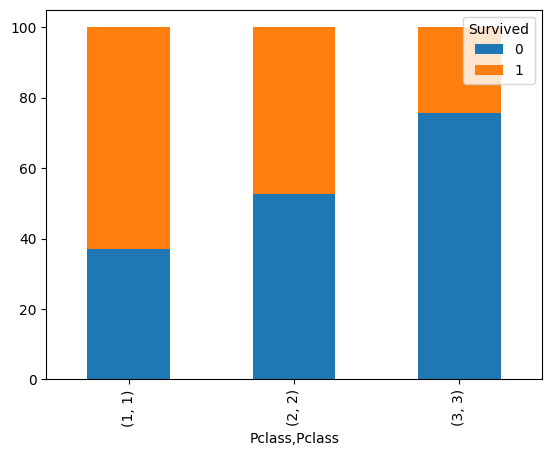

In [ ]:
from os import defpath
df.groupby(['Pclass', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['Pclass', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

Se observa que la clase en la que viajan los pasajeron tiene infuencia en la probabilidad de sobrevivir.
Clase 1 tiene mayor problabilidad de sobrevivir y Clase 3 la menor.

**Sex**

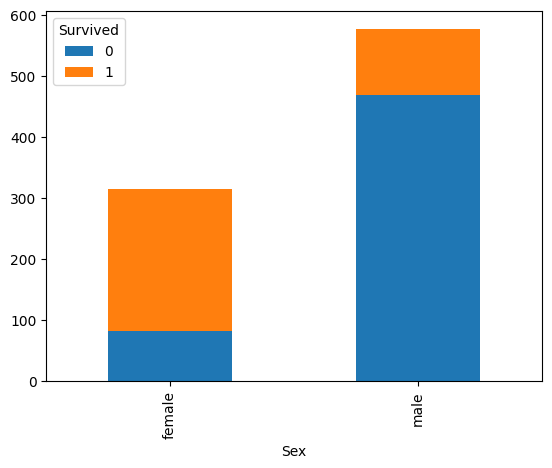

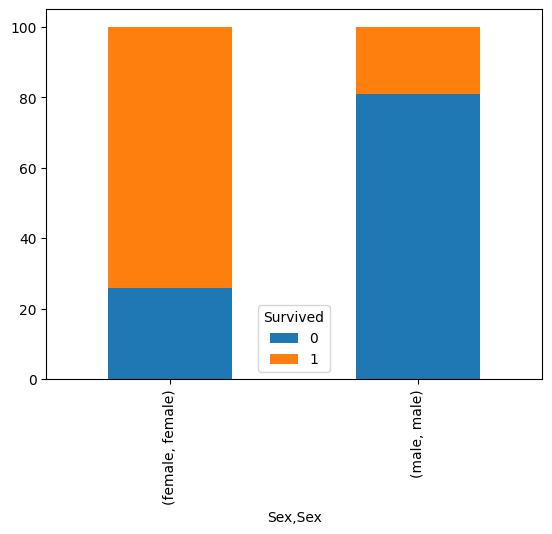

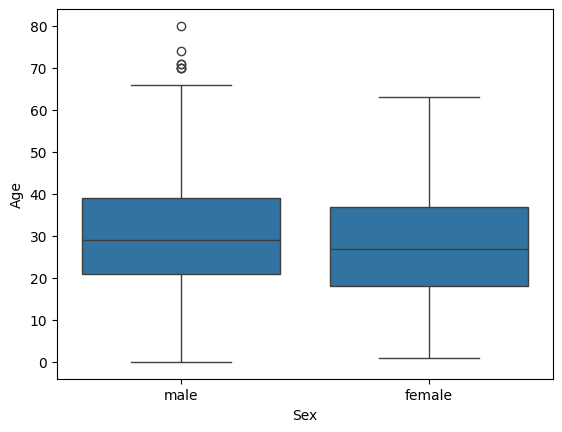

In [ ]:
from os import defpath
df.groupby(['Sex', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['Sex', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()
sn.boxplot(x="Sex", y="Age", data=df)
plt.show()

Igualmente el género, si bien hay menos mujeres la probablidad de sobrevivir el considerablemente mayor a los hombres.

**SibSp**

 Número de hermanos o cónyuges a bordo

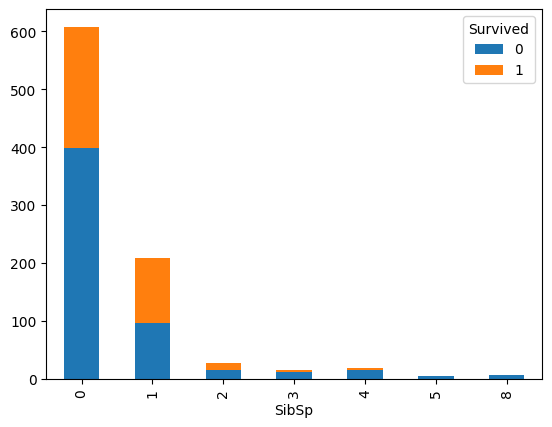

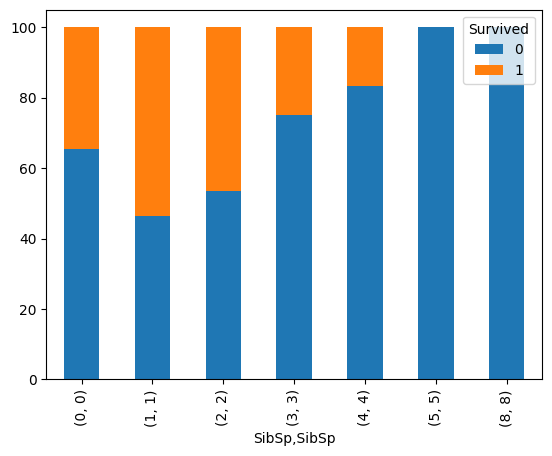

In [ ]:
from os import defpath
df.groupby(['SibSp', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['SibSp', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()


Se observa que si bien hay más personas sin hermanos ni cónyuges, la probabilidad de sobrevivir de aquellos con 1 o 2 familiares es mayor.

**Parch**

Número de padres o hijos a bordo

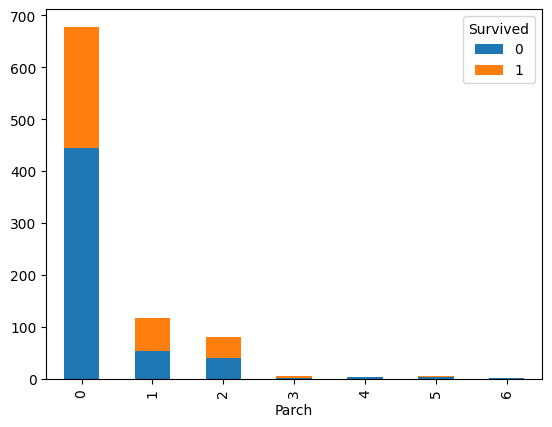

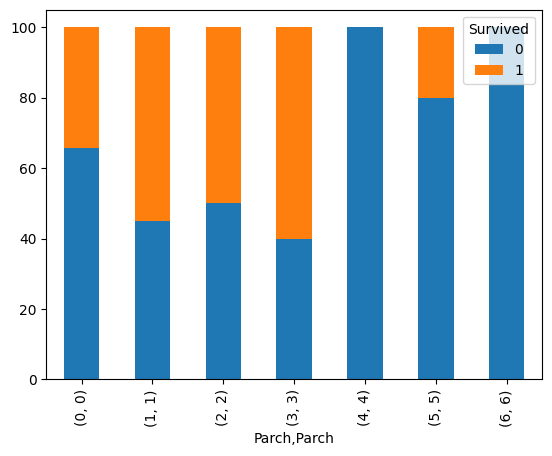

In [ ]:
from os import defpath
df.groupby(['Parch', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['Parch', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()


Se observa un comportamiento similar a la variable anterior.

**Fare**

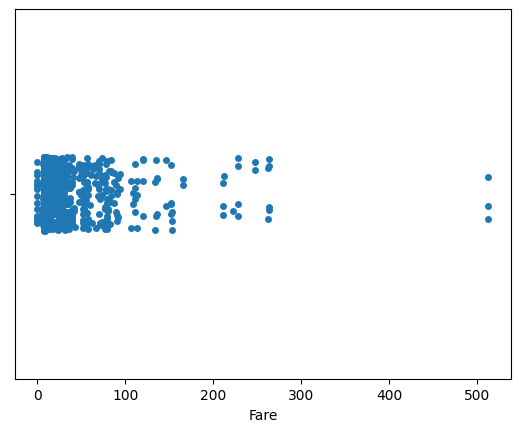

----------------------------------------------------------------------
Mínimo:  0.0
Máximo:  512.3292
----------------------------------------------------------------------
Casos de más de 300 dolares de tarifa:  3


In [ ]:
from os import defpath
import seaborn as sn

sn.stripplot(x='Fare', data=df)
plt.show()

print("----------------------------------------------------------------------")
print("Mínimo: ", df['Fare'].min())
print("Máximo: ", df['Fare'].max())
print("----------------------------------------------------------------------")

print("Casos de más de 300 dolares de tarifa: ", df[df['Fare']>300]['Fare'].count())

Se observan outlier, aquellos registros superior a 300 dolares.

Agrupan los datos de Fare para poder visualizar mejor la tendencia de la variable objetivo.



/tmp/ipython-input-287113024.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()
/tmp/ipython-input-287113024.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()
/tmp/ipython-input-287113024.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

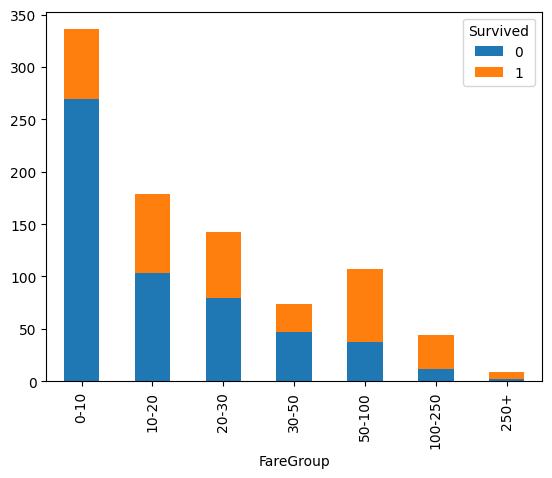

/tmp/ipython-input-287113024.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
/tmp/ipython-input-287113024.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)


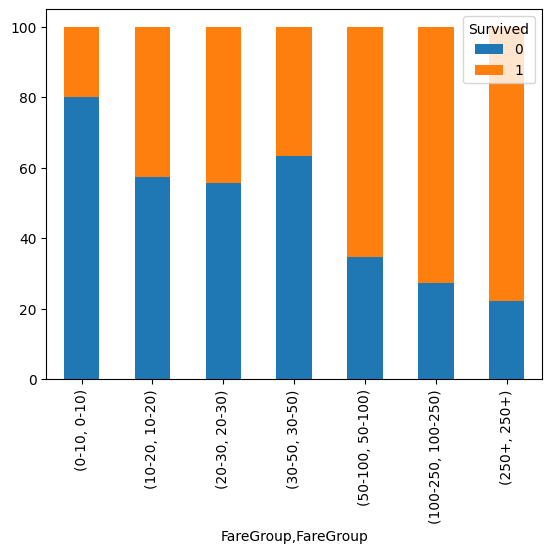

In [ ]:
# Agrupar la variable 'Fare' en rangos
fare_bins = [0, 10, 20, 30, 50, 100, 250, df['Fare'].max()]
fare_labels = ['0-10', '10-20', '20-30', '30-50', '50-100', '100-250', '250+']
df['FareGroup'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels, include_lowest=True)

# Calcular proporciones de sobrevivientes por grupo de tarifa
fare_survival = df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

df.groupby(['FareGroup', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['FareGroup', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

del df['FareGroup']

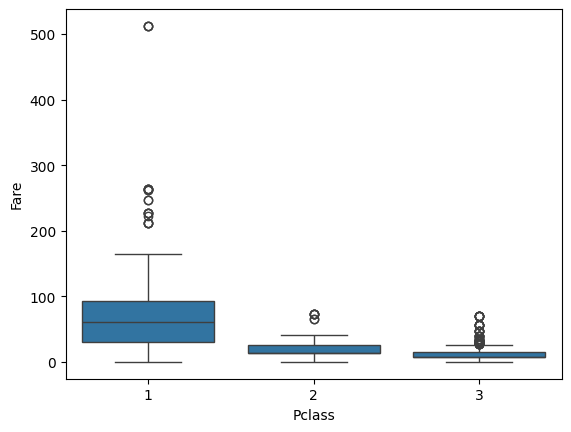

In [ ]:
sn.boxplot(x="Pclass", y="Fare", data=df)
plt.show()

Se observa que los boletos más caros tienen mayor probabilidad de sobrevivir.

**Embarked**

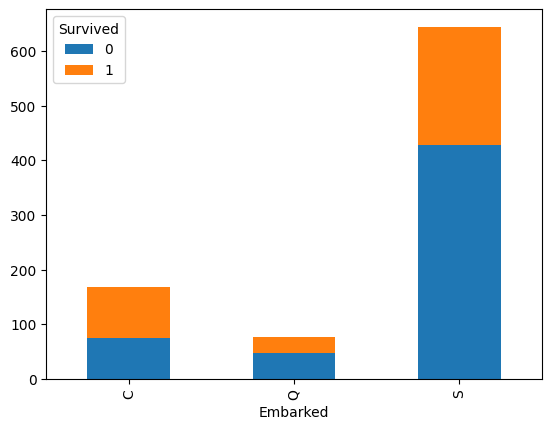

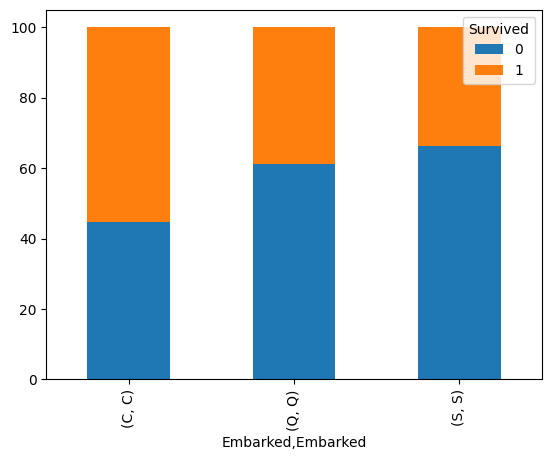

In [ ]:
from os import defpath
df.groupby(['Embarked', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()
df.groupby(['Embarked', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

El puerto en el que embarcan tienen infuencia sobre la variable de decisión.

**PassengerID**

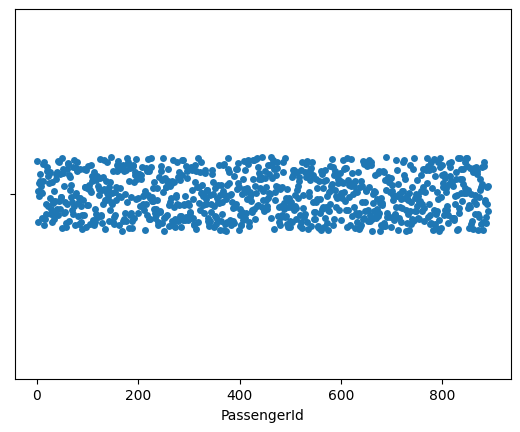

,Ticket
PassengerId,
1,1
2,1
3,1
4,1
5,1
...,...
887,1
888,1
889,1


In [ ]:
import seaborn as sn
from os import defpath
sn.stripplot(x='PassengerId', data=df)
plt.show()

df['PassengerId'].drop_duplicates()
df.groupby('PassengerId')['Ticket'].count()

Es un correlativo, por lo que no aporta en el modelo.

In [ ]:
df.groupby('Name')['Ticket'].count()

,Ticket
Name,
"Abbing, Mr. Anthony",1
"Abbott, Mr. Rossmore Edward",1
"Abbott, Mrs. Stanton (Rosa Hunt)",1
"Abelson, Mr. Samuel",1
"Abelson, Mrs. Samuel (Hannah Wizosky)",1
...,...
"de Mulder, Mr. Theodore",1
"de Pelsmaeker, Mr. Alfons",1
"del Carlo, Mr. Sebastiano",1


Son unicamente los nombres de los pasaje por lo que no aporta en el modelo.

In [ ]:
df.groupby('Ticket')['Fare'].count()

,Fare
Ticket,
110152,3
110413,3
110465,2
110564,1
110813,1
...,...
W./C. 6608,4
W./C. 6609,1
W.E.P. 5734,1


Son los tickets de los pasajeros, donde hay 681 valores distintos de los 891 registros totales, por lo que no aportaría valor.

¿Qué variables no aportan a la toma de decisión del modelo?
* PassengerID
* Name
* Tiket

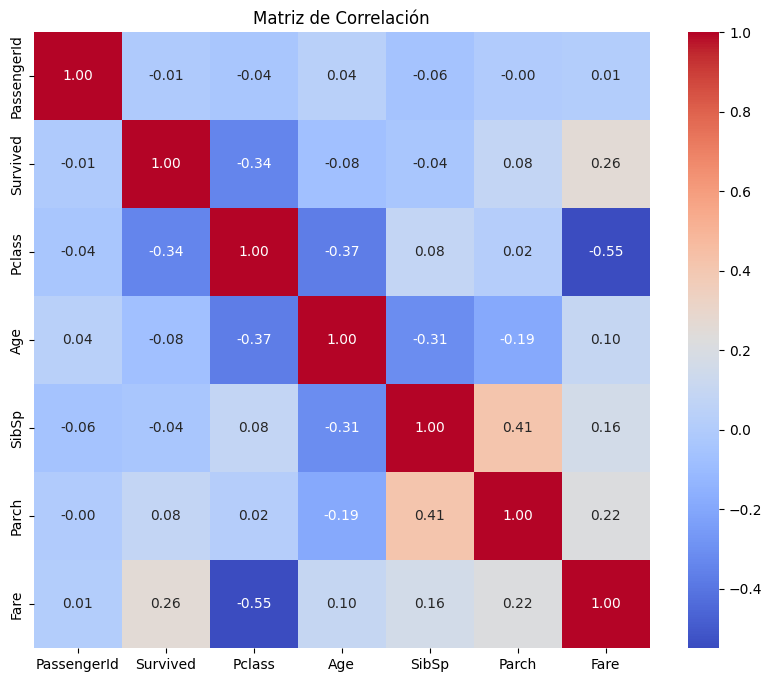

In [ ]:
df_matriz = df.copy()
import seaborn as sns
del df_matriz['Name'], df_matriz['Sex'], df_matriz['Ticket'], df_matriz['Cabin'], df_matriz['Embarked']
correlation_matrix = df_matriz.corr()

# Mostrar como heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación")
plt.show()

Se observan las correlaciones entre variables:
* Fare esta negativamente correlacionada con Pclass --> Cuando aumenta la tarifa disminuye la clase.
* También se observa que estas dos presentan mayor influencia en la variable dependiente (Survived).


### **Limpieza de datos**

La limpieza de datos es eliminar las inconsistencias encontradas en el análisis exploratorio de datos, como valores perdidos y valores atípicos.


#### **Inconsistencias/Outliers**
Se observaron inconsistencias en Fare, por lo que se eliminan los registros con estas condiciones:

In [ ]:
print(df[df['Fare'] > 300].head())

df.loc[df['Fare'] > 300, ['Fare']] = np.nan


     PassengerId  Survived  Pclass                                Name  \
258          259         1       1                    Ward, Miss. Anna   
679          680         1       1  Cardeza, Mr. Thomas Drake Martinez   
737          738         1       1              Lesurer, Mr. Gustave J   

        Sex   Age  SibSp  Parch    Ticket      Fare        Cabin Embarked  
258  female  35.0      0      0  PC 17755  512.3292          NaN        C  
679    male  36.0      0      1  PC 17755  512.3292  B51 B53 B55        C  
737    male  35.0      0      0  PC 17755  512.3292         B101        C  


Dejamos nulos aquellos valores atípicos.

Además, eliminamos aquellas variables categóricas o correlativas que no aportan valor:
* PassengerID
* Name
* Ticket

In [ ]:
del df['PassengerId'], df['Name'], df['Ticket']

In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


#### **Imputación de datos**

Existen distintos métodos de imputación de datos:

**1. Si son menos de un <5%**: se puede eliminar o reemplazar nulos por moda (categóricos)/mediana (numéricos).

**2. Si es más de un 5%**: imputar usando los valores de las observaciones más cercanas (vecinos más similares).

**3. Si es más de un 30%**: se debe eliminar la variable.

**Age**

Esta presenta un 20% de sus datos nulos, pero al ser una variable relevante, se deben imputan los datos faltantes.

Se usa el método de imputación mediante vecinos más cercanos.

In [ ]:

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df[['Age']] = imputer.fit_transform(df[['Age']])

**Fare**

Dado que en Fare existen solo 3 casos nulos, reemplazaremos por la mediana.

In [ ]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,687
Embarked,2


Se observa que no quedan valores nulos en Edad ni Fare.
Y quedan dos registros vacios en las variables categóricas: Puerto de Embarque (y +70% en Cabin).

In [ ]:
df[df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


Para registros categóricos, donde el número de nulos es <5%, se reemplaza por la moda.

In [ ]:
mode_embarked = df['Embarked'].mode()
df['Embarked'].fillna(mode_embarked[0], inplace=True)
mode_embarked

/tmp/ipython-input-4124051512.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(mode_embarked[0], inplace=True)


,Embarked
0,S


Para aquellas variables con más de un 30% de datos faltantes, no es viable hacer imputación de datos, por lo que debemos quitarlas de nuestro dataset:
* Cabin

In [ ]:
del df['Cabin']

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


No quedan registros nulos.


In [ ]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### **Agregación**
Agrupar categorías o números para reducir y mejorar calidad predictiva.

**Embarked**

Se observa que el puerto de embarque Q y S presentan un comportamiento similar, además, la categoría Q es poco representativa (no se observan tantos registros), por lo tanto, se agrupan en una única categoría.


In [ ]:
float(df[df['Embarked']=='Q']['Survived'].count()/df.shape[0])

0.08641975308641975

In [ ]:
df['Embarked'] = df['Embarked'].replace('Q', 'Q-S')
df['Embarked'] = df['Embarked'].replace('S', 'Q-S')

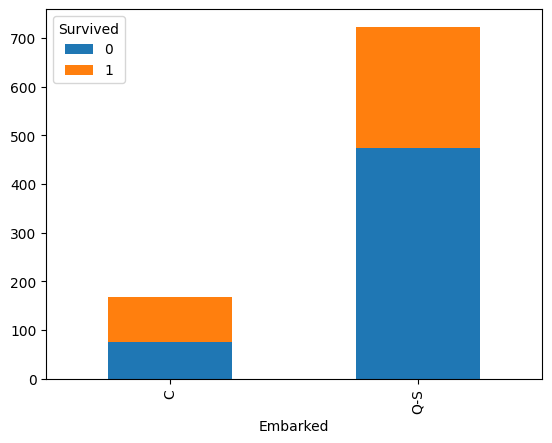

In [ ]:
df.groupby(['Embarked', 'Survived']).size().unstack().plot.bar(stacked=True)
plt.show()

**SibSp**
Se observa que el comportamiento es similar entre para aquellos con más de una esposa/esposo o hermanos. Por lo tanto, lo agrupamos:

In [ ]:
(df.groupby('SibSp')['Survived'].sum()/df.groupby('SibSp')['Survived'].count()*100).round(1)

,Survived
SibSp,
0,34.5
1,53.6
2,46.4
3,25.0
4,16.7
5,0.0
8,0.0


In [ ]:
df.groupby('SibSp')['Survived'].count()

,Survived
SibSp,
0,608
1,209
2,28
3,16
4,18
5,5
8,7


Si bien la probabilidad de sobrevivencia disminuye desde los 3 parientes, los registros disminuyen considerablemente, por lo que no es una categoría significativa.

In [ ]:
df['SibSp_Ag'] = 0
df.loc[df['SibSp'] > 0, 'SibSp_Ag'] = 1

In [ ]:
(df.groupby('SibSp_Ag')['Survived'].sum()/df.groupby('SibSp_Ag')['Survived'].count()*100).round(1)

,Survived
SibSp_Ag,
0,34.5
1,46.6


Donde se observa que aquellos con hermanos/esposo/esposa presentan mayor probabilidad de sobrevivir.

**Parch**

Padres/Hijos

In [ ]:
(df.groupby('Parch')['Survived'].sum()/df.groupby('Parch')['Survived'].count()*100).round(1)

,Survived
Parch,
0,34.4
1,55.1
2,50.0
3,60.0
4,0.0
5,20.0
6,0.0


In [ ]:
df.groupby('Parch')['Survived'].count()

,Survived
Parch,
0,678
1,118
2,80
3,5
4,4
5,5
6,1


Se observa el mismo comportamiento anterior, aquellos con hijos o padres tienen mayor probabilidad de sobrevivir, por lo que agrupamos para no tener categorías tan poco significativas.

In [ ]:
df['Parch_Ag'] = 0
df.loc[df['Parch'] > 0, 'Parch_Ag'] = 1

In [ ]:
(df.groupby('Parch_Ag')['Survived'].sum()/df.groupby('Parch_Ag')['Survived'].count()*100).round(1)

,Survived
Parch_Ag,
0,34.4
1,51.2


#### **Transformación a variables binarias**
Principalmente las categóricas.

In [ ]:
df = pd.get_dummies(df, columns = ["Embarked"], drop_first=True)
df = pd.get_dummies(df, columns = ["Sex"], drop_first=True)

In [ ]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,SibSp_Ag,Parch_Ag,Embarked_Q-S,Sex_male
0,0,3,22.000000,1,0,7.2500,1,0,True,True
1,1,1,38.000000,1,0,71.2833,1,0,False,False
2,1,3,26.000000,0,0,7.9250,0,0,True,False
3,1,1,35.000000,1,0,53.1000,1,0,True,False
4,0,3,35.000000,0,0,8.0500,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0,0,True,True
887,1,1,19.000000,0,0,30.0000,0,0,True,False
888,0,3,29.693277,1,2,23.4500,1,1,True,False
889,1,1,26.000000,0,0,30.0000,0,0,False,True


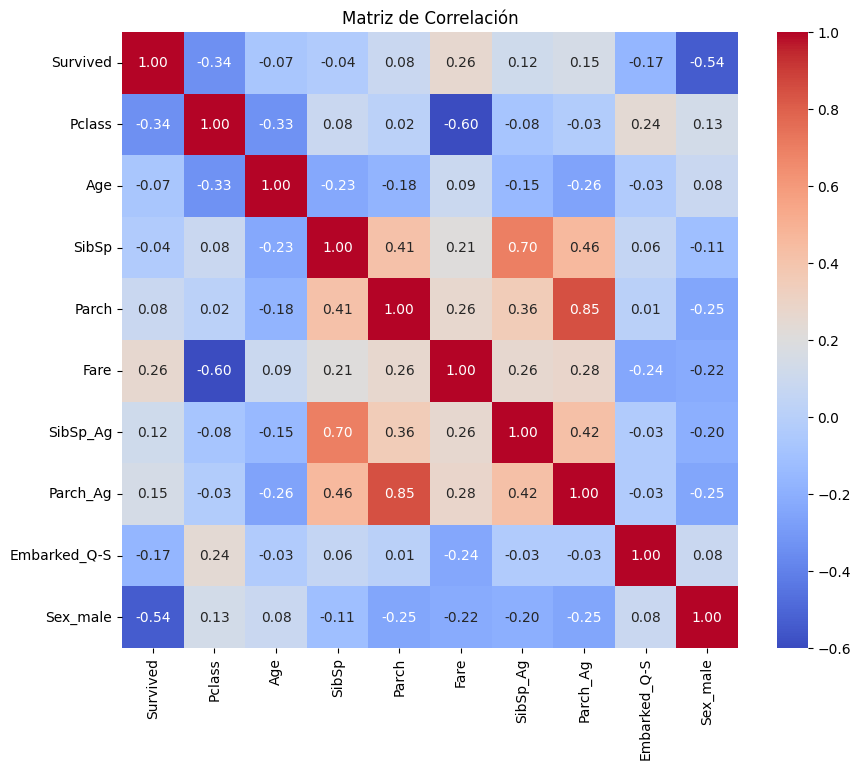

In [ ]:
# Mostrar como heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación")
plt.show()

* Se observa que las variables Parch_Ag y SibSP_Ag estan fuertemente correlacionadas --> se podría crear una variable nueva con ambas. Y ambas, presentan mejor correlación con la variable Survived respecto a su versión no agregada.
* Fare y PClass también se encuentran correlacionadas.
* Sex_male tiene alta influencia en la variable objetivo.
* Age podría agruparse para mejorar la correlación con la variable objetivo.
* Embarqued_Q_S también presenta impacto en la variable Survived.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = df.copy()
y = df['Survived']
del X['Survived']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.model_selection import train_test_split

# Ajustar modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print(f"Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.80
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       157
           1       0.80      0.70      0.75       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Al entrenar un modelo de Regresión Logística con el 70% de la data y testear con el 30% restante, se obtiene un 80% de accuracy, es decir, se predijo correctamente el 80% de casos (verdaderos positivos y verdaderos negativos).